#Trabalho 1
##Filas e Ruína do Apostador
##Modelagem e Avaliação de Desempenho

## Entrega Preliminar

### Alunos:
Daniel Corcino de Albuquerque - DRE: 118188457

Letícia Freire Carvalho de Sousa - DRE: 118025324

Lucas Favilla Ferreira Alves da Silva - DRE: 119156518

Roberto Leonie Ferreira Moreira - DRE: 116062192



## Simulação

Fizemos uma simulação em que passamos como parâmetros:

$\lambda$ - taxa da variável exponencial que modela o tempo entre as chegadas dos clientes  

$\mu$ - taxa da variável exponencial que modela a vida residual dos clientes

`LIM_TIME` - Tempo limite que passamos aceitando novos clientes na fila de espera

Após passarmos do tempo limite terminamos a simulação com os clientes que já estavam na fila de espera.


Estamos computando os ciclos de vida do servidor (do nascimento a morte) bem como seus ciclos ociosos.

### Métricas

Para entrega preliminar computamos:

  $E(N)$ = valor esperado do número de clientes no sistema, a cada momento

  $E(Nq)$ = número de clientes na fila de espera, a cada chegada de novo cliente

  $E(X)$ = valor esperado do tempo de serviço prestado a cada cliente

  $E(W)$ = valor esperado do tempo na fila de espera de cada cliente

  $E(T)$ = valor esperado do tempo de cada cliente no sistema


In [ ]:
import numpy as np
import random
import copy
import time
from queue import PriorityQueue

# A simulacao em si
def simulation(LAMBDA, MU, LIM_TIME, QUEUE_MAX_SIZE = -1, VERBOSE = 0):

  # Medidas interessantes a serem analisadas
  class Measures:
    def __init__(self):
      #variaveis auxiliares para as medidas
      self.TotalClients = 0 # número total de clientes que passaram pelo sistema
      self.area_Nq = 0 #  somatorio do número de clientes na fila de espera a cada momento
      self.T = 0 # somatorio do tempo total gasto no sistema por cada cliente
      self.W = 0 # somatorio do tempo total gasto na fila de espera por cada cliente
      self.X = 0 # somatorio do tempo total gasto em serviço por cada cliente
      self.count_arrivals = 0 # numero total de arrivals
      self.sum_service_time = 0 # somatorio do tempo de servico

      self.area_N = 0 # somatorio do número de clientes no sistema a cada momento
      self.area_N_y = [] # área do gráfico N vs T a cada momento
      self.area_N_x = [] # momentos de mudança da área do N vs T

      self.count_idle_cycles = 0 # numero de ciclos ociosos
      self.count_birth_and_death_processes = 0 # numero de ciclos de vida e morte
      self.sum_idle_cycles_time = 0 # somatorio da duração de cada ciclo ocioso
      self.sum_birth_and_death_processes_time = 0 # somatorio da duração de cada ciclo de vida e morte
      self.sim_time = 0 # tempo total de simulação

    # add X to N_area at time T
    def change_N_Area(self, X, T):
      self.area_N += X
      self.area_N_y.append(self.area_N)
      self.area_N_x.append(T)
      if(VERBOSE > 1):
        print(f"Adicionando area {X} - area total {self.area_N} - {self.area_N_y[len(self.area_N_y)-1]}")


    # valor esperado do número de clientes no sistema, a cada momento
    def Expected_Value_N(self):
      return self.area_N / self.sim_time

    # valor esperado do número de clientes na fila de espera, a cada chegada de novo cliente
    def Expected_Value_Nq(self):
      return self.area_Nq / self.sim_time

    # valor esperado da porcentagem do tempo em que o sistema está ativo
    def Expected_Value_Rho(self):
      return self.sum_birth_and_death_processes_time / self.sim_time

    # valor esperado do tempo de serviço prestado a cada cliente
    def Expected_Value_X(self):
      return self.X / self.TotalClients

    # valor esperado do tempo na fila de espera de cada cliente
    def Expected_Value_W(self):
      return self.W / self.TotalClients

    # valor esperado do tempo de cada cliente no sistema
    def Expected_Value_T(self):
      return self.T / self.TotalClients

    # valor esperado de lambda pela lei de Little
    def Real_Lambda(self):
      return self.Expected_Value_N() / self.Expected_Value_T()

    # valor esperado de mu pela lei de little
    def Real_Mu(self):
      return 1 / self.Expected_Value_X()



  # classe que modela os eventos de chegada e saída de cada cliente no sistema
  # id -- id do cliente -- incremental a partir de 1
  # event_type -- tipo do evento ("A" - chegada, "D" - saída)
  # arrival_time -- momento da chegada no sistema
  # departure_time -- momento de saída do sistema
  # service_start -- momento em que começa a ser serviço
  # time -- momento atual, pode ser igual a arrival_time ou departure_time, a depender
  #         de qual evento está sendo modelado

  class Event:
    def __init__(self, event_type, time, id):
      self.event_type = event_type
      self.time = time
      self.service_start = -1
      if(event_type == 'A'):
        self.arrival_time = self.time
        self.departure_time = -1
      else:
        self.departure_time = self.time
      self.id = id

    # para imprimir de forma expressiva os dados do cliente
    def __str__(self):
      if(self.event_type == "A"):
        return str(self.id) + "\t|\t"+str(f"{self.arrival_time:.3f}").format()+ "\t|"
      return str(self.id) + "\t|\t" + str(f"{self.arrival_time:.3f}") + "\t|\t"
      + str(f"{self.service_start:.3f}") + "\t|\t" + str(f"{self.departure_time:.3f}") + "\t|"

    # comparador, utilizado para sabermos que evento vem primeiro
    # em caso de empate damos prioridade para a saída do sistema
    def __lt__(self, other):
      if(self.time<other.time):
          return True
      if(self.time>other.time):
          return False
      else:
          return (self.event_type == 'D')

  # o tempo de vida residual é modelado por uma variavel aleatória exponencial com taxa MU
  def residual_life():
    return random.expovariate(MU)

  # o momento da proxima chegada é modelado pela soma de variaveis aleatórias exponenciais iid com taxa LAMBDA
  ARRIVAL_TIME = 0
  def next_arrival():
    return ARRIVAL_TIME + random.expovariate(LAMBDA)

  # classe para modelar o sistema
  # waiting_queue -- lista que representa a fila de espera (células são do tipo Event)
  # server -- variável do tipo Event que representa o cliente que está sendo servido
  class System:
    def __init__(self, queue_max_size = -1):
      self.waiting_queue = []
      self.server = None
      self.queue_max_size = queue_max_size

    # cliente e entra na lista de espera
    def arrival(self, e):
      if(self.queue_max_size == -1 or self.waiting_queue_size() < self.queue_max_size - 1):
        self.waiting_queue.append(e)

    # cliente que está sendo servido sai do sistema
    # garantidamente só é chamado se o sistema estava ocupado
    def departure(self):
      server = copy.deepcopy(self.server)
      self.server = None
      return server

    # o próximo cliente sai da fila de espera e é servido
    def next(self, T):
      if(self.busy() or not(self.waiting_queue)):
        return None
      self.server = self.waiting_queue.pop(0)
      x = residual_life()
      measures.X += x
      self.server.departure_time = T + x
      self.server.time = self.server.departure_time
      return self.server

    # verifica se o sistema está ocupado
    def busy(self):
      return not(self.server == None)

    # tamanho da fila de espera
    def waiting_queue_size(self):
      return len(self.waiting_queue)

    # tamanho da fila (fila de espera + servidor)
    def full_queue_size(self):
      s = len(self.waiting_queue)
      if(self.busy()):
        s += 1
      return s

    # para imprimir de forma expressiva os dados dos clientes na fila
    # imprimimos os dados de no máximo 5 clientes para não poluir a simulação
    def __str__(self):
      ans = "\tServidor: \n"
      ans += "\033[1m"+"\tid\t|\tchegada\t|\tservidor|\tsaída\t|\n"+"\033[0m"
      ans += "\t" + str(self.server) + "\n"


      ans += "\n \tFila de Espera: ("+ str(self.waiting_queue_size())+ ") \n"

      ans += "\033[1m"+"\tid\t|\tchegada\t|\n"+"\033[0m"

      lim = 5
      for w in self.waiting_queue:
        ans += "\t" + str(w) + " \n"
        lim -= 1
        if(lim == 0):
          ans += "\t...\n"
          break
      ans += "---------------------------------------\n"
      return ans



  # variáveis principais
  system = System(QUEUE_MAX_SIZE)
  measures = Measures()
  eventQueue = PriorityQueue()

  id = 0 # id do próximo cliente que chegará

  ARRIVAL_TIME = 0
  # evento de chegada do próximo cliente
  # é inicializado fora do laço principal para que a simulção comece com um cliente no sistema
  eventQueue.put(Event('A', ARRIVAL_TIME, id))

  T = 0 # tempo atual
  birth = -1 # tempo do último nascimento, -1 se ocioso
  death = -1 # tempo da última morte, -1 se é o primeiro ciclo de vida e morte
  count_clients = 0 # número total de clientes que passaram pelo sistema no ciclo de vida e morte atual

  # tempo total de simulação
  measures.sim_time = LIM_TIME
  # laço principal da simulação
  # Quando a simulação chega ao tempo limite paramos a simulação
  while(T < LIM_TIME):
    # evento atual, pode ser de chegada ou de saída
    current_event = eventQueue.get()

    # atualizamos tempo atual da simulação
    last_T = T
    T = current_event.time

    # somatório do número de clientes no sistema a cada momento
    measures.change_N_Area(system.full_queue_size() * (T - last_T), T)
    #measures.area_N += system.full_queue_size() * (T - last_T)

    # somatório do número de clientes na fila de espera a cada momento
    measures.area_Nq += system.waiting_queue_size() * (T - last_T)

    if(VERBOSE > 1):
      print(f"\nCurrent event time: {T:.3f}\n")

    # se o evento atual é de chegada
    if(current_event.event_type == "A"):
      if(VERBOSE > 1):
        print("Arrival event: ")

      id += 1
      ARRIVAL_TIME = next_arrival()
      next_arrival_event = Event('A', ARRIVAL_TIME, id)
      eventQueue.put(next_arrival_event)

      if(not(system.waiting_queue_size() == system.queue_max_size)):

        # numero total de clientes que passaram pelo sistema
        measures.TotalClients += 1

        count_clients += 1
        if(birth == -1):
          birth = T

          # se estamos começando novo ciclo de vida e morte
          if(not(death == -1)):
            # atualizamos várias métricas:

            # número de ciclos ociosos
            measures.count_idle_cycles += 1

            # somatorio da duração de cada ciclo ocioso
            measures.sum_idle_cycles_time += birth - death

            if(VERBOSE > 1):
              print(f"servidor ocioso de {death:.3f} ate {birth:.3f}")
        system.arrival(current_event)

    # se o evento atual é de partida
    else:
      if(VERBOSE > 1):
        print("Departure event: ")
        print("\033[1m"+"id\t|\tchegada\t|\tservidor|\tsaída\t|\n"+"\033[0m")
        print(current_event)

      # atualizamos a métrica do tempo total do cliente no sistema
      measures.T += current_event.departure_time - current_event.arrival_time
      # cliente termina de ser servido
      system.departure()

    serving = system.next(T)
    # se um cliente começou a ser servido neste momento
    if(serving):
      # somatório do tempo que cada cliente passa na fila de espera
      measures.W += T - serving.arrival_time

      # gerando o evento de saída do cliente do sistema
      serving.service_start = T
      serving.event_type = 'D'
      next_departure_event = serving
      eventQueue.put(next_departure_event)

    # se o sistema está ocioso
    if(not(system.busy())):
      death = T
      # atualizamos várias métricas:

      # número de ciclos de vida e morte
      measures.count_birth_and_death_processes += 1

      # somatorio da duração de cada ciclo de vida e morte
      measures.sum_birth_and_death_processes_time += death - birth

      if(VERBOSE > 1):
        print(f"servidor ficou ativo de {birth:.3f} ate {death:.3f} e atendeu {count_clients} clientes")
      count_clients = 0
      birth = -1

      if(VERBOSE > 1):
        print("")
    if(VERBOSE > 1):
      print(system)


  if(VERBOSE > 0):
    print("Métricas obtidas:")
    print(f"E[T] =  {measures.Expected_Value_T():.3f}")
    print(f"E[W] =  {measures.Expected_Value_W():.3f}")
    print(f"E[X] =  {measures.Expected_Value_X():.3f}")
    print("")
    print(f"E[N] =  {measures.Expected_Value_N():.3f}")
    print(f"E[Nq] =  {measures.Expected_Value_Nq():.3f}")
    print(f"E[Rho] =  {measures.Expected_Value_Rho():.3f}")
    print("")
    print(f"Lambda =  {measures.Real_Lambda():.3f}")
    print(f"Mu =  {measures.Real_Mu():.3f}")

  return measures


In [ ]:
simulation(1, 2, 100000, 5, 1)

Métricas obtidas:
E[T] =  0.908
E[W] =  0.414
E[X] =  0.493

E[N] =  0.907
E[Nq] =  0.414
E[Rho] =  0.493

Lambda =  0.999
Mu =  2.027


<__main__.simulation.<locals>.Measures at 0x79eef4b86980>

## Resultado das simulações

In [ ]:
import matplotlib.pyplot as plt

def grafico_area_n_t(area_N, time_sim, LAMBDA, MU):
  area_N_over_t = copy.deepcopy(area_N)
  time_sim_copy = copy.deepcopy(time_sim)
  area_N_over_t.pop(0)
  time_sim_copy.pop(0)
  for i in range(len(area_N_over_t)):
    area_N_over_t[i] /= time_sim_copy[i]

  plt.plot(time_sim_copy, area_N_over_t)
  plt.xlabel('T')
  plt.ylabel('E(N)')
  plt.title(f'E(N) vs T  (lambda = {LAMBDA}, mu = {MU})')
  plt.show()

  plt.plot(time_sim, area_N)
  plt.xlabel('T')
  plt.ylabel('A')
  plt.title(f'(Área N) vs T (lambda = {LAMBDA}, mu = {MU})')
  plt.show()


def experiment(LAMBDA, MU, QUEUE_MAX_SIZE = -1, MAX_ITERATIONS = 20):
  LIM_TIME = 100000
  T = 1.96

  averages = {"T": 0.0, "W": 0.0, "X":0.0, "N":0.0, "Nq": 0.0, "Rho": 0.0, "Lambda": 0.0, "Mu": 0.0}
  variances = {"T": 0.0, "W": 0.0, "X":0.0, "N":0.0, "Nq": 0.0, "Rho": 0.0}
  std_dev = {"T": 0.0, "W": 0.0, "X":0.0, "N":0.0, "Nq": 0.0, "Rho": 0.0}
  results = {"T": [], "W": [], "X":[], "N":[], "Nq":[], "Rho": [], "Lambda": [], "Mu": []}
  confidence_interval = {"T": [], "W": [], "X":[], "N":[], "Nq":[], "Rho": []}


  def calc_average(s):
    n = len(s)
    total = 0
    for x in s:
      total += x
    return total / n

  def calc_variance(s, average):
    n = len(s)
    if(n == 1):
      return 0.0
    total = 0
    for x in s:
      total += (x - average) ** 2
    return total / (n - 1)


  def calc_confidence_interval(t):
    return [averages[key] - t * std_dev[key] / ((it+1)**0.5), averages[key] + t * std_dev[key] / ((it+1)**0.5)]

  time_sim = []
  area_N = []

  for it in range(MAX_ITERATIONS):
    current = simulation(LAMBDA, MU, LIM_TIME, QUEUE_MAX_SIZE)

    time_sim = copy.deepcopy(current.area_N_x)
    area_N = copy.deepcopy(current.area_N_y)

    results["T"].append(current.Expected_Value_T())
    results["W"].append(current.Expected_Value_W())
    results["X"].append(current.Expected_Value_X())
    results["N"].append(current.Expected_Value_N())
    results["Nq"].append(current.Expected_Value_Nq())
    results["Rho"].append(current.Expected_Value_Rho())
    results["Lambda"].append(current.Real_Lambda())
    results["Mu"].append(current.Real_Mu())

    print(f"Rodada {it+1}")


    for key, value in results.items():
      averages[key] = calc_average(value)
      if(key == "Lambda" or key == "Mu"):
        print(f" {key} obtido {averages[key]:.3f}")
      else:
        variances[key] = calc_variance(value, averages[key])
        std_dev[key] = variances[key] ** (1/2)
        confidence_interval[key] = calc_confidence_interval(T)
        print(f" {key} média {averages[key]:.3f} variancia {variances[key]:.6f} desvio padrão {std_dev[key]:.6f}\\
         intervalo de confiança: ({confidence_interval[key][0]:.3f}, {confidence_interval[key][1]:.3f})")

    print()


  grafico_area_n_t(area_N, time_sim, LAMBDA, MU)





#Resultado dos experimentos

## Filas infinitas

Abaixo apresentamos o resultado dos experimentos, cada um com 20 simulações com os valores sugeridos no enunciado e LIM_TIME = 100000.

Também plotamos os seguintes gráficos para a última simulação:
    

1.   (Área embaixo da função N vs T) vs (T)
2.   (Área embaixo da função N/t vs T) vs (T)


    

Rodada 1
 T média 0.994 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.994, 0.994)
 W média 0.495 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.495, 0.495)
 X média 0.498 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.498, 0.498)
 N média 0.992 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.992, 0.992)
 Nq média 0.494 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.494, 0.494)
 Rho média 0.498 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.498, 0.498)
 Lambda obtido 0.998
 Mu obtido 2.006

Rodada 2
 T média 1.001 variancia 0.000123 desvio padrão 0.011093 intervalo de confiança: (0.986, 1.017)
 W média 0.502 variancia 0.000101 desvio padrão 0.010062 intervalo de confiança: (0.488, 0.516)
 X média 0.499 variancia 0.000001 desvio padrão 0.001036 intervalo de confiança: (0.498, 0.501)
 N média 1.001 variancia 0.000163 desvio padrão 0.012771 intervalo de confia

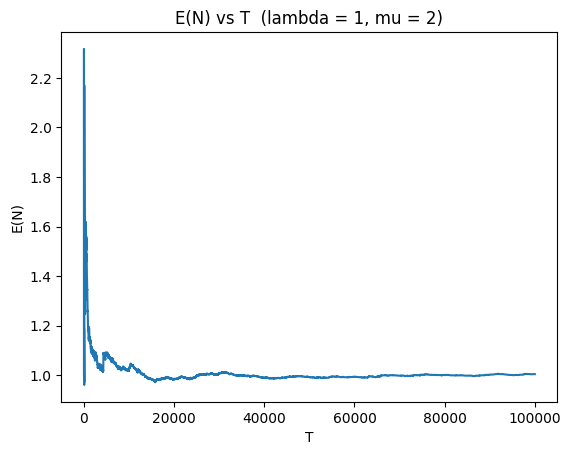

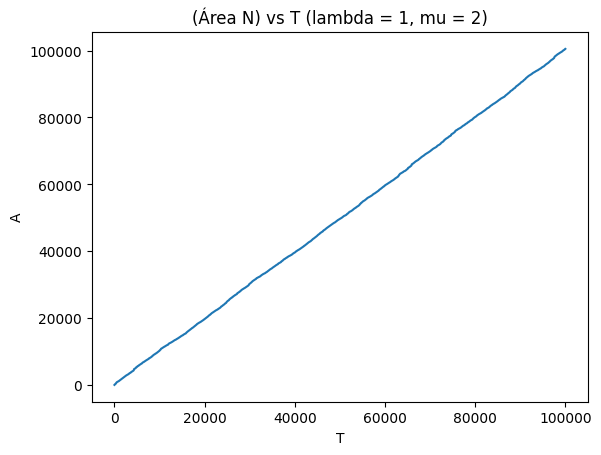

In [ ]:
experiment(1, 2)

Rodada 1
 T média 0.499 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.499, 0.499)
 W média 0.250 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.250, 0.250)
 X média 0.249 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.249, 0.249)
 N média 0.997 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.997, 0.997)
 Nq média 0.499 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.499, 0.499)
 Rho média 0.498 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.498, 0.498)
 Lambda obtido 1.998
 Mu obtido 4.012

Rodada 2
 T média 0.500 variancia 0.000001 desvio padrão 0.001106 intervalo de confiança: (0.498, 0.501)
 W média 0.250 variancia 0.000001 desvio padrão 0.000874 intervalo de confiança: (0.249, 0.251)
 X média 0.249 variancia 0.000000 desvio padrão 0.000231 intervalo de confiança: (0.249, 0.250)
 N média 0.998 variancia 0.000005 desvio padrão 0.002163 intervalo de confia

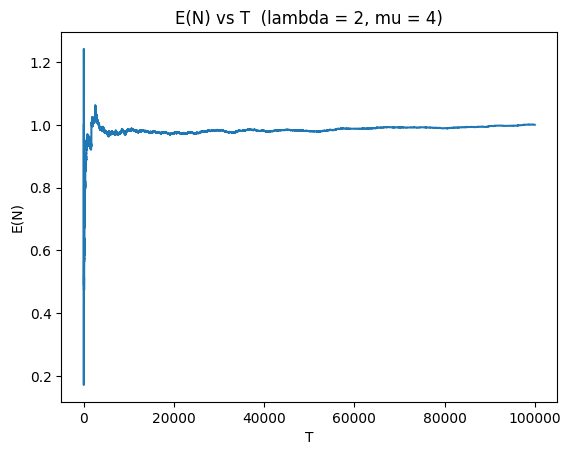

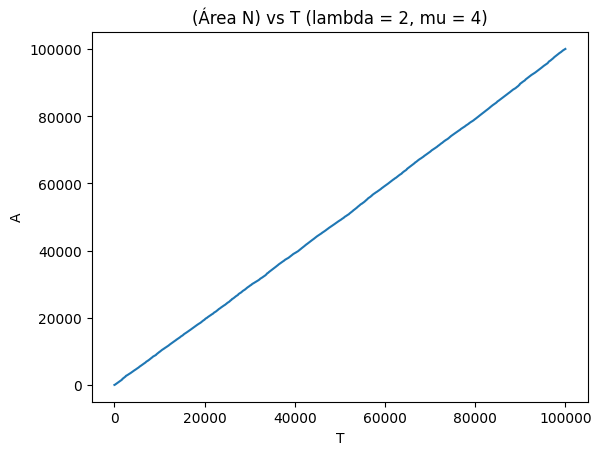

In [ ]:
experiment(2, 4)

Rodada 1
 T média 2273.129 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2273.129, 2273.129)
 W média 2272.224 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2272.224, 2272.224)
 X média 0.950 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.950, 0.950)
 N média 2511.673 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2511.673, 2511.673)
 Nq média 2510.673 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2510.673, 2510.673)
 Rho média 0.009 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.009, 0.009)
 Lambda obtido 1.105
 Mu obtido 1.052

Rodada 2
 T média 2300.248 variancia 1470.877096 desvio padrão 38.352016 intervalo de confiança: (2247.095, 2353.401)
 W média 2299.342 variancia 1470.794648 desvio padrão 38.350941 intervalo de confiança: (2246.191, 2352.494)
 X média 0.952 variancia 0.000005 desvio padrão 0.002140 intervalo de confiança: (0.949, 0.955)
 N média 2540.

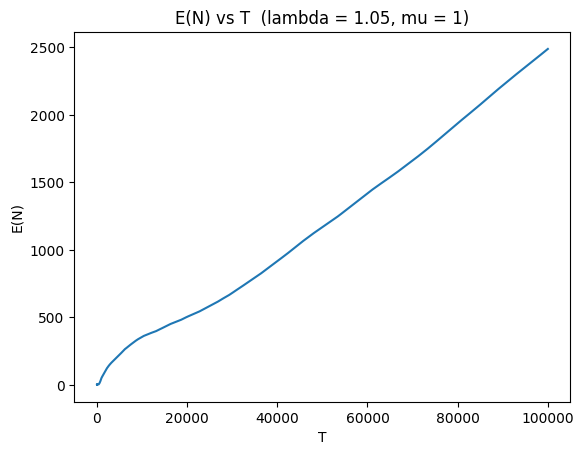

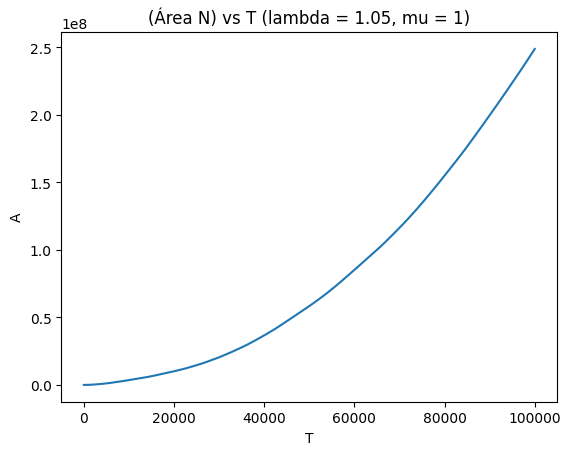

In [ ]:
experiment(1.05, 1)

Rodada 1
 T média 4412.871 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (4412.871, 4412.871)
 W média 4412.053 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (4412.053, 4412.053)
 X média 0.905 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.905, 0.905)
 N média 5391.743 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (5391.743, 5391.743)
 Nq média 5390.743 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (5390.743, 5390.743)
 Rho média 0.000 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.000, 0.000)
 Lambda obtido 1.222
 Mu obtido 1.105

Rodada 2
 T média 3961.799 variancia 406931.049127 desvio padrão 637.911474 intervalo de confiança: (3077.699, 4845.899)
 W média 3960.967 variancia 406957.273059 desvio padrão 637.932029 intervalo de confiança: (3076.838, 4845.095)
 X média 0.911 variancia 0.000063 desvio padrão 0.007965 intervalo de confiança: (0.900, 0.922)
 N média

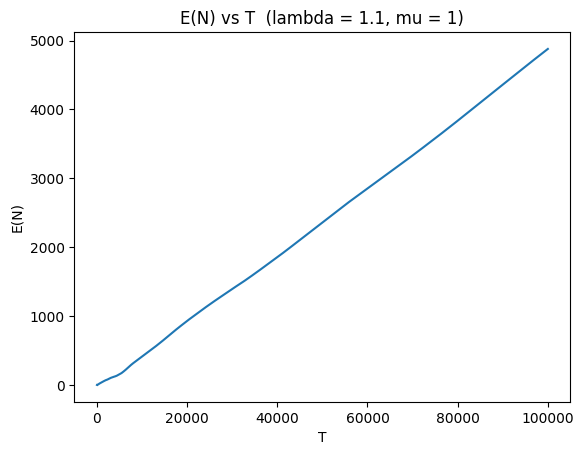

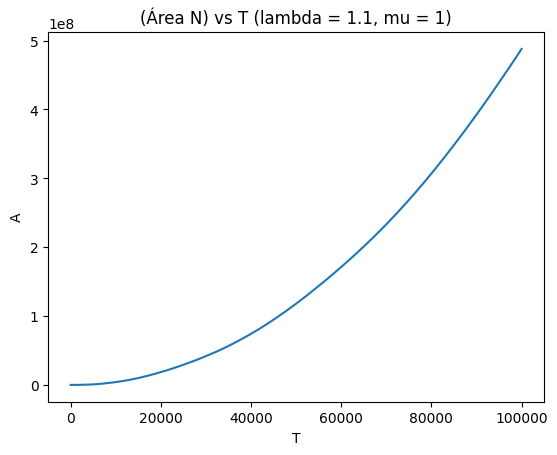

In [ ]:
experiment(1.10, 1)

## Filas Finitas

Abaixo apresentamos o resultado dos experimentos, cada um com 5 simulações com os valores sugeridos no enunciado e LIM_TIME = 100000.

Rodada 1
 T média 2.516 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2.516, 2.516)
 W média 1.705 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (1.705, 1.705)
 X média 0.812 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.812, 0.812)
 N média 2.650 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2.650, 2.650)
 Nq média 1.796 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (1.796, 1.796)
 Rho média 0.855 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.855, 0.855)
 Lambda obtido 1.053
 Mu obtido 1.232

Rodada 2
 T média 2.518 variancia 0.000005 desvio padrão 0.002273 intervalo de confiança: (2.515, 2.521)
 W média 1.706 variancia 0.000002 desvio padrão 0.001562 intervalo de confiança: (1.704, 1.708)
 X média 0.812 variancia 0.000000 desvio padrão 0.000658 intervalo de confiança: (0.811, 0.813)
 N média 2.650 variancia 0.000000 desvio padrão 0.000194 intervalo de confia

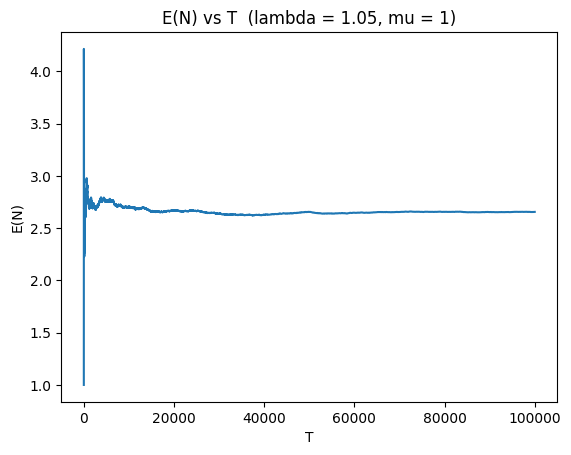

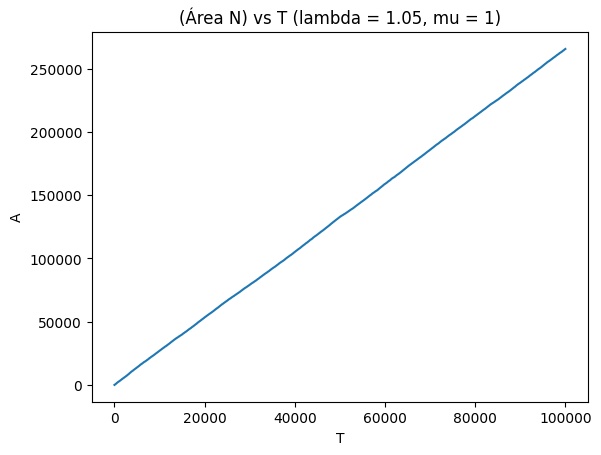

In [ ]:
experiment(1.05, 1, 5)

Rodada 1
 T média 2.531 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2.531, 2.531)
 W média 1.739 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (1.739, 1.739)
 X média 0.792 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.792, 0.792)
 N média 2.789 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (2.789, 2.789)
 Nq média 1.916 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (1.916, 1.916)
 Rho média 0.873 variancia 0.000000 desvio padrão 0.000000 intervalo de confiança: (0.873, 0.873)
 Lambda obtido 1.102
 Mu obtido 1.263

Rodada 2
 T média 2.536 variancia 0.000056 desvio padrão 0.007488 intervalo de confiança: (2.526, 2.546)
 W média 1.742 variancia 0.000020 desvio padrão 0.004436 intervalo de confiança: (1.736, 1.748)
 X média 0.794 variancia 0.000009 desvio padrão 0.003051 intervalo de confiança: (0.790, 0.798)
 N média 2.787 variancia 0.000011 desvio padrão 0.003360 intervalo de confia

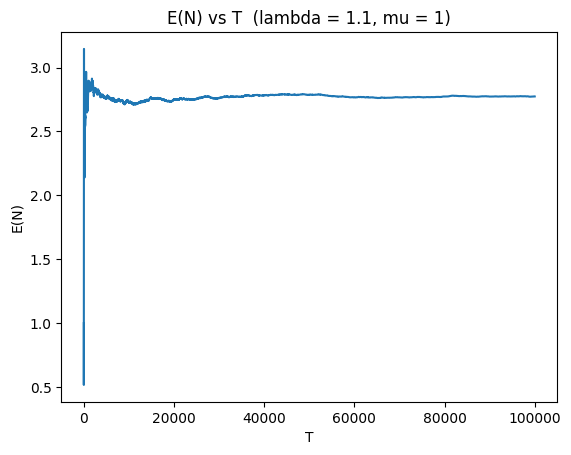

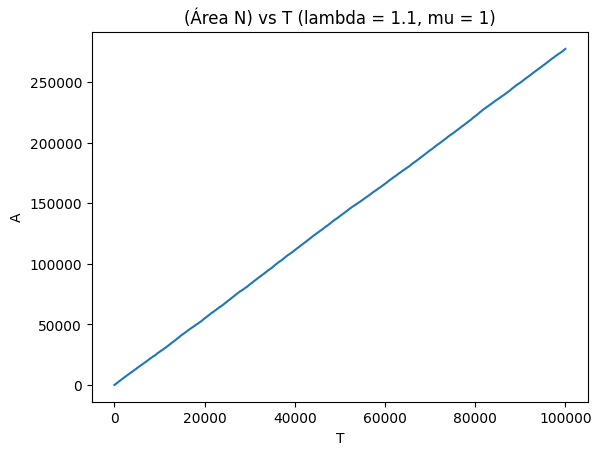

In [ ]:
experiment(1.10, 1, 5)

# Espaço de Teste

Abaixo temos uma célula em que podemos testar diferentes valores de $\mu$, $\lambda$ e LIM_TIME.

Além disso, há um parâmetro extra booleano VERBOSE.

Quando passamos VERBOSE = 2 nós mostramos cada evento de chegada e saída de clientes do sistema, além dos resultados das métricas calculadas.

Quando passamos VERBOSE = 1 nós mostramos somente resultados das métricas calculadas.


Quando passamos VERBOSE = 0 não mostramos nada.


In [ ]:
# print("   SIMULAÇÃO   ")
# LAMBDA = float(input("Taxa lambda (momentos de chegada) : "))
# MU = float(input("Taxa mu (vida residual) : "))
# LIM_TIME = float(input("Tempo máximo aceitando novos clientes (s): "))
# QUEUE_MAX_SIZE = int(input("Tamanho máximo da fila de espera (-1, se ilimitada)"))
# VERBOSE = int(input("Verbose? (0 - Não imprime nada; 1 - Imprime métricas obtidas; 2 - Imprime a simulação dos eventos e métricas obtidas)"))
# simulation(LAMBDA, MU, LIM_TIME, QUEUE_MAX_SIZE, VERBOSE)

#Ruína do Apostador

Abaixo executamos algumas simulações computando se primeiro a fila esvazia (equivalente a ruína do apostador), se a fila enche, no caso das filas finitas (fortuna do apostador) ou se a fila nunca esvazia durante o tempo de simulação (no caso das infinitas).

No caso das finitas só paramos a simulação quando a fila enche ou esvazia.

Colhemos as métricas relacionadas ao número médio de passos até a fila esvaziar e também ao tempo esperado para tanto.



In [ ]:
import numpy as np
import random
import copy
import time
from queue import PriorityQueue

# A simulacao em si
def gambler_simulation(LAMBDA, MU, LIM_TIME, QUEUE_MAX_SIZE = -1):
  # classe que modela os eventos de chegada e saída de cada cliente no sistema
  # id -- id do cliente -- incremental a partir de 1
  # event_type -- tipo do evento ("A" - chegada, "D" - saída)
  # arrival_time -- momento da chegada no sistema
  # departure_time -- momento de saída do sistema
  # service_start -- momento em que começa a ser serviço
  # time -- momento atual, pode ser igual a arrival_time ou departure_time, a depender
  #         de qual evento está sendo modelado

  class Event:
    def __init__(self, event_type, time, id):
      self.event_type = event_type
      self.time = time
      self.service_start = -1
      if(event_type == 'A'):
        self.arrival_time = self.time
        self.departure_time = -1
      else:
        self.departure_time = self.time
      self.id = id

    # comparador, utilizado para sabermos que evento vem primeiro
    # em caso de empate damos prioridade para a saída do sistema
    def __lt__(self, other):
      if(self.time<other.time):
          return True
      if(self.time>other.time):
          return False
      else:
          return (self.event_type == 'D')

  # o tempo de vida residual é modelado por uma variavel aleatória exponencial com taxa MU
  def residual_life():
    return random.expovariate(MU)

  # o momento da proxima chegada é modelado pela soma de variaveis aleatórias exponenciais iid com taxa LAMBDA
  ARRIVAL_TIME = 0
  def next_arrival():
    return ARRIVAL_TIME + random.expovariate(LAMBDA)

  # classe para modelar o sistema
  # waiting_queue -- lista que representa a fila de espera (células são do tipo Event)
  # server -- variável do tipo Event que representa o cliente que está sendo servido
  class System:
    def __init__(self, queue_max_size = -1):
      self.waiting_queue = []
      self.server = None
      self.queue_max_size = queue_max_size

    # cliente e entra na lista de espera
    def arrival(self, e):
      if(self.queue_max_size == -1 or self.waiting_queue_size() < self.queue_max_size - 1):
        self.waiting_queue.append(e)

    # cliente que está sendo servido sai do sistema
    # garantidamente só é chamado se o sistema estava ocupado
    def departure(self):
      server = copy.deepcopy(self.server)
      self.server = None
      return server

    # o próximo cliente sai da fila de espera e é servido
    def next(self, T):
      if(self.busy() or not(self.waiting_queue)):
        return None
      self.server = self.waiting_queue.pop(0)
      x = residual_life()
      self.server.departure_time = T + x
      self.server.time = self.server.departure_time
      return self.server

    # verifica se o sistema está ocupado
    def busy(self):
      return not(self.server == None)

    # tamanho da fila de espera
    def waiting_queue_size(self):
      return len(self.waiting_queue)

    # tamanho da fila (fila de espera + servidor)
    def full_queue_size(self):
      s = len(self.waiting_queue)
      if(self.busy()):
        s += 1
      return s

  gambler_ruin = -1

  # variáveis principais
  system = System(QUEUE_MAX_SIZE)
  eventQueue = PriorityQueue()

  id = 0 # id do próximo cliente que chegará

  ARRIVAL_TIME = 0
  # evento de chegada do próximo cliente
  # é inicializado fora do laço principal para que a simulção comece com um cliente no sistema
  eventQueue.put(Event('A', ARRIVAL_TIME, id))

  T = 0 # tempo atual
  P = 0 # número de passos

  # laço principal da simulação
  # Quando a simulação chega ao tempo limite paramos a simulação
  while(T < LIM_TIME and gambler_ruin == -1):

    # evento atual, pode ser de chegada ou de saída
    current_event = eventQueue.get()

    # atualizamos tempo atual da simulação
    last_T = T
    T = current_event.time

    # atualizamos número de passos
    P += 1

    # se o evento atual é de chegada
    if(current_event.event_type == "A"):

      id += 1
      ARRIVAL_TIME = next_arrival()
      next_arrival_event = Event('A', ARRIVAL_TIME, id)
      eventQueue.put(next_arrival_event)
      system.arrival(current_event)

      if(system.full_queue_size() == system.queue_max_size):
        gambler_ruin = 0 # apostador consegue fortuna
        break

    # se o evento atual é de partida
    else:
      # cliente termina de ser servido
      system.departure()

    serving = system.next(T)
    # se um cliente começou a ser servido neste momento
    if(serving):

      # gerando o evento de saída do cliente do sistema
      serving.service_start = T
      serving.event_type = 'D'
      next_departure_event = serving
      eventQueue.put(next_departure_event)

    # se o sistema está ocioso
    if(not(system.busy())):
      gambler_ruin = 1 # apostador cai em ruina
      break


  return [gambler_ruin, T, P]


In [ ]:
def gambler_experiment(LAMBDA, MU, QUEUE_MAX_SIZE = -1, MAX_ITERATIONS = 40):
  LIM_TIME = 1000000
  T = 1.96

  ruin_prob = 0 # probabilidade de se arruinar
  ruin_expected_time = 0 # numero esperado de tempo para se arruinar, dado que se arruinou
  ruin_expected_steps = 0 # numero esperado de passos para se arruinar, dado que se arruinou

  for it in range(MAX_ITERATIONS):
    gambler_ruin = gambler_simulation(LAMBDA, MU, LIM_TIME, QUEUE_MAX_SIZE)
    if(gambler_ruin[0] == 1): # apostador se arruinou
      ruin_prob += 1
      ruin_expected_time += gambler_ruin[1]
      ruin_expected_steps += gambler_ruin[2]
    elif(gambler_ruin[0] == 0):
      print("Se afortunou (a fila encheu)")

  ruin_expected_time /= ruin_prob
  ruin_expected_steps /= ruin_prob
  ruin_prob /= MAX_ITERATIONS

  print(f"Probabilidade de se aruinar: {ruin_prob}")
  print(f"Tempo esperado para se arruinar, dado que se arruinou é: {ruin_expected_time:.3f}")
  print(f"Número de passos esperado para se arruinar, dado que se arruinou é: {ruin_expected_steps:.3f}")

In [ ]:
gambler_experiment(1, 2, -1)

Probabilidade de se aruinar: 1.0
Tempo esperado para se arruinar, dado que se arruinou é: 0.935
Número de passos esperado para se arruinar, dado que se arruinou é: 3.900


In [ ]:
gambler_experiment(2, 4, -1)

Probabilidade de se aruinar: 1.0
Tempo esperado para se arruinar, dado que se arruinou é: 0.473
Número de passos esperado para se arruinar, dado que se arruinou é: 3.700


In [ ]:
gambler_experiment(1.05, 1, -1)

Probabilidade de se aruinar: 0.975
Tempo esperado para se arruinar, dado que se arruinou é: 10.885
Número de passos esperado para se arruinar, dado que se arruinou é: 23.333


In [ ]:
gambler_experiment(1.10, 1, -1)

Probabilidade de se aruinar: 0.975
Tempo esperado para se arruinar, dado que se arruinou é: 3.743
Número de passos esperado para se arruinar, dado que se arruinou é: 9.026


In [ ]:
gambler_experiment(1.05, 1, 5)

Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Probabilidade de se aruinar: 0.875
Tempo esperado para se arruinar, dado que se arruinou é: 1.297
Número de passos esperado para se arruinar, dado que se arruinou é: 3.886


In [ ]:
gambler_experiment(1.10, 1, 5)

Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Se afortunou (a fila encheu)
Probabilidade de se aruinar: 0.825
Tempo esperado para se arruinar, dado que se arruinou é: 1.282
Número de passos esperado para se arruinar, dado que se arruinou é: 3.879
